In [1]:
# Numpy and pandas for manipulating the data
import numpy as np
import pandas as pd

# Matplotlib and seaborn for visualization
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

# Performance metrics from sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

# Statsmodel for modeling trends and time series analysis
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.arima_model import ARIMA

# There will be some warnings in statsmodels that we can ignore
import warnings
warnings.filterwarnings("ignore")

/home/jshuai/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Read in the file
by_date_total_file = './data/cleaned/by_date_total.csv'
by_date_total_df = pd.read_csv(by_date_total_file, parse_dates=True, index_col=0)

In [3]:
# Styling
# make figures bigger
mpl.rcParams['figure.figsize'] = 9, 6

# change grid line styling
mpl.rcParams['grid.color'] = '#d6dbdf'
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['grid.linewidth'] = 0.5

# change font
mpl.rcParams['font.family'] = 'Open Sans'

mpl.rcParams['axes.prop_cycle'] = plt.cycler(color=['#6377cb', '#b9bac2'])

In [4]:
# Define some functions so we can visualize and train our data easier
def get_time_series(by_date_total_df, period='M', year='2017'):
    ''' Resample (summing incidents from all states) and split the data into train and test sets.
    '''
    time_series = by_date_total_df.resample(period).sum().sum(axis=1)
    time_series.index = pd.to_datetime(time_series.index)

    train_series = time_series[:year]
    test_series = time_series[year:]
    return train_series, test_series

def check_stationary(time_series):
    ''' Check for stationarity using the Dicky-Fuller test.
    '''
    test_results = adfuller(time_series, autolag='AIC')
    results_df = pd.Series(test_results[1:4], index=['p value','n_lags','n_obs'])
    return results_df
    
def train_arima(X_train, X_test, p=3, d=1, q=0):
    '''Trains an arima model, making predictions on each X_test value 
    '''
    history = list(X_train)
    train_len = len(X_train)
    predictions = []

    for sample in X_test:
        # Train the model and make a forecast
        model = ARIMA(history, order=(p, d, q))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()

        # Keep track of our predictions, and add a ground truth to our history
        predictions.append(output[0][0])
        history.append(sample)

    print("MSE: {}".format(mean_squared_error(predictions, X_test)))

    return model, predictions

def plot_predictions(history, truth, predictions):
    '''Plots the truth alongside the predictions and visualize how good the time forecasting model is.
    '''
    history = list(history)
    truth = list(truth)
    predictions = list(predictions)

    plt.plot(history + truth, label='truth')
    plt.plot(history + predictions, label='predictions', color='r')
    plt.legend()
    plt.tight_layout()
    plt.show()

def get_shift(time_series, shift_amt=1):
    ''' Calculates shift_amt order differencing to remove trend.
    '''
    shifted = time_series - time_series.shift(shift_amt)
    return shifted.dropna()

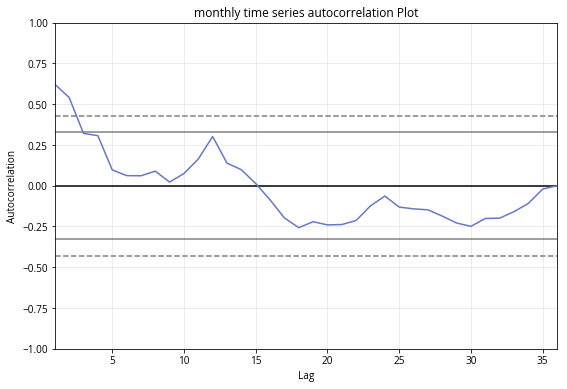

In [5]:
# Get monthly time series; with training set from 2014-215 and testing from 2016-2017
monthly_ts = get_time_series(by_date_total_df, 'M', '2016')

# Show the autocorrelation plot for the training series
autocorrelation_plot(monthly_ts[0]) 
plt.title('monthly time series autocorrelation Plot')
plt.show()

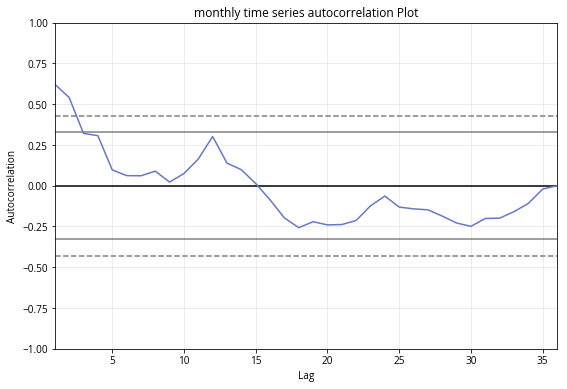

In [6]:
# Show the autocorrelation plot for the training series
autocorrelation_plot(monthly_ts[0]) 
plt.title('monthly time series autocorrelation Plot')
plt.show()

In [7]:
# Check stationarity for different orders of difference
for i in range(5):
    results = check_stationary(get_shift(monthly_ts[0], i + 1))
    print("---{} order difference---\n{}".format(i + 1, results))

---1 order difference---
p value    3.604195e-08
n_lags     1.000000e+01
n_obs      2.400000e+01
dtype: float64
---2 order difference---
p value    5.071492e-09
n_lags     9.000000e+00
n_obs      2.400000e+01
dtype: float64
---3 order difference---
p value     0.612139
n_lags     10.000000
n_obs      22.000000
dtype: float64
---4 order difference---
p value    5.913741e-09
n_lags     7.000000e+00
n_obs      2.400000e+01
dtype: float64
---5 order difference---
p value     0.005077
n_lags      9.000000
n_obs      21.000000
dtype: float64


MSE: 11504.010531408603


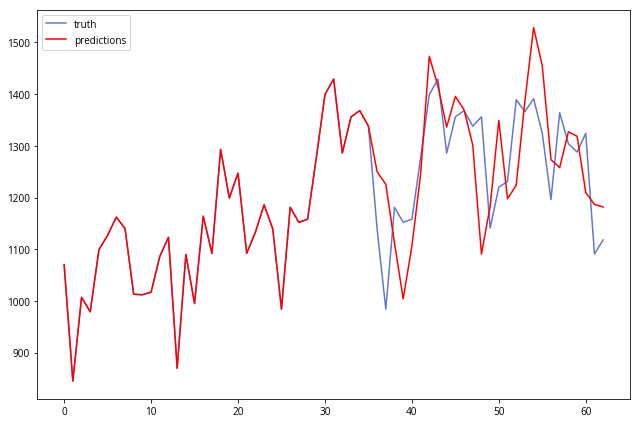

In [8]:
# Use the 2nd order difference and a lag of 12 (a full year) to train an ARIMA model
monthly_model, monthly_preds = train_arima(*monthly_ts, p=12, d=2, q=0)
plot_predictions(*monthly_ts, monthly_preds)

In [9]:
# Find which model did better

# Turn the predictions lists into Series so we can manipulate it easier
monthly_preds = pd.Series(monthly_preds)

# Calculate the rate of change between each month
change_rates_truth = (monthly_ts[1] - monthly_ts[1].shift()) / monthly_ts[1].shift()
change_rates_truth =  change_rates_truth.dropna()

change_rates_preds = (monthly_preds - monthly_preds.shift()) / monthly_preds.shift()
change_rates_preds =  change_rates_preds.dropna()

# See if the predictions can predict tell whether murder rates go up by more than 5%
accuracy = accuracy_score(change_rates_truth > 0.05, change_rates_preds > 0.05)
print("Accuracy score w/o log transform: {}".format(accuracy))

Accuracy score w/o log transform: 0.6538461538461539
